In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from utils_data_reader import get_datasets_pytorch, prep_data_range, move_alt_axis_for_numpy
from utils_plot import plot_rho_24, get_rho_at_date

# Step 1. Reading Datasets

The process of reading and reshaping data is relatively straightforward, so these functions are separated into `utils_data_reader.py`.

## 1.1 Data Shape Conventions

Initially, the data shape is (N, 24, 20, 36), corresponding to N, lst, lat, and alt. However, the paper by Briden aims to reduce the altitude dimension, and PyTorch's API expects the second axis to be reduced. Therefore, the shape for the neural network needs to be adjusted.

The expected shape for the neural network is (N, 36, 24, 20).


In [2]:

# Pytorch's Dataset objects. By default, reading in log10
train, val, test, original_trainset= get_datasets_pytorch(train_ds=[2011, 2012, 2013, 2014, 2015, 2016], test_ds=[2017], train_ratio=0.8, shuffle=True)



Preparing training data...
Loading data for year 2011
Loading data for year 2012
Loading data for year 2013
Loading data for year 2014
Loading data for year 2015
Loading data for year 2016
Concatenating data...
Preparing test data...
Loading data for year 2017
Concatenating data...
Train Set Shape: (41972, 36, 20, 24)
Val Set Shape:  (10492, 36, 20, 24)
Test Set Shape: (8736, 36, 20, 24)


## 1.2 Input Data Standardization and Scaling

In general, it is a well-known practice to input standardized data to the neural network (NN) as it can converge more stably. Since the original data represents air density, the values are small, ranging from $10^{-16} to 10^{-7}$. Thus, it is reasonable to map the data to a log10 scale. Next, the data is standardized by calculating the mean and standard deviation. Finally, the standardized data is scaled to the range [0, 1]. This information is saved as a "data_stats.json" file for future use, such as testing the NN.

The steps mentioned above are outlined below.

### 1.2.1 Log 10

data = log10(original data)

### 1.2.2 Standardization
data = (data - mean(data))/std(data)

### 1.2.3 Scale to [0, 1]
data = (data-min(data))/(max(data) - min(data))



In [3]:
class StandardScaler():
    def __init__(self, data) -> None:
        self.mean = np.mean(data)
        self.std = np.std(data)
    
    def transform(self, data):
        data = (data - self.mean) / self.std
        self.min = np.min(data)
        self.max = np.max(data)
        data = (data - self.min) / (self.max - self.min)
        return data
    
    def inverse_transform(self, data):
        data = data * (self.max - self.min) + self.min
        data = data * self.std + self.mean
        return data

ss = StandardScaler(original_trainset)

# # Now, all NN's input is scaled to [0, 1]
train.data = ss.transform(train.data)
val.data = ss.transform(val.data)
test.data = ss.transform(test.data)


# Step 2. Defining the Encoder and Decoder

An encoder is implemented to reduce the original data axis for altitutde. As the filters of the CNN iterates the logititude and latitude axis for the density, it can be a reasonable choice. In a way, the altittude axis resembles to that of image color channel.

Once the data is encoded, a decoder, a set of Deconvolutional layers, are added. Once the decoder outputs the orignal size of the data, it will be compared with the input data to calculate the loss. By comparing the loss that is small after the decoder, it is reasonable to assume the reduced information by the encoder has intelligently compressed the data to address dimensionality reduction process that was done by multiple pipelines in the paper.

In the code, for the simplicity and the readibilty of the implementation, the ecoder, decoder are separately implemented. Finally, the extra audoencoder class is defined to put them together.

In [4]:
class Encoder(nn.Module):
    def __init__(self,):
        super(Encoder, self).__init__()
        # 2D convolutional layers
        self.conv1 = nn.Conv2d(36, 5, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(5)
        self.conv2 = nn.Conv2d(5, 1, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(1)
        
        # Fully connected layers
        self.fc1 = nn.Linear(480, 96)
        self.fc2 = nn.Linear(96, 32)
        self.fc3 = nn.Linear(32, 10)
        
    def forward(self, x):
        x = self.bn1(F.relu(self.conv1(x)))
        x = self.bn2(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        # Fully connected layers
        self.fc1 = nn.Linear(10, 64)
        self.fc2 = nn.Linear(64, 512)
        
        # 2D transposed convolutional layers, expecting: (N, 256, 1, 2) 
        self.deconv1 = nn.ConvTranspose2d(256, 82, kernel_size=5, stride=1, padding=0, output_padding=0)
        self.bn1 = nn.BatchNorm2d(82)
        self.deconv2 = nn.ConvTranspose2d(82, 60, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.bn2 = nn.BatchNorm2d(60)
        self.deconv3 = nn.ConvTranspose2d(60, 36, kernel_size=3, stride=2, padding=1, output_padding=1)
        # self.bn3 = nn.BatchNorm2d(36)
        # # Additional ConvTranspose2d layers
        # self.deconv4 = nn.ConvTranspose2d(36, 36, kernel_size=3, stride=1, padding=1, output_padding=0)
        # self.bn4 = nn.BatchNorm2d(36)
        # self.deconv5 = nn.ConvTranspose2d(36, 36, kernel_size=3, stride=1, padding=1, output_padding=0)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = x.view(x.size(0), 256, 1, 2)
        x = self.bn1(F.relu(self.deconv1(x)))
        x = self.bn2(F.relu(self.deconv2(x)))
        x = self.deconv3(x)
        
        # x = self.bn3(F.relu(self.deconv3(x)))
        # x = self.bn4(F.relu(self.deconv4(x)))
        # x = self.deconv5(x)

        return x

class Autoencoder(nn.Module):
    def __init__(self, encoder, decoder):
        super(Autoencoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        
    def forward(self, x):
        z = self.encoder(x)
        x_reconstructed = self.decoder(z)
        return x_reconstructed

### Sanity Check
Printing the data shapes layer by layer. Compare with the paper. Note that altitude axis (36) is in 2nd axis for the sake of pytorch API.

In [5]:
def trace_encoder_shapes(encoder, input_data):
    print("Tracing Encoder Shapes")
    x = input_data
    print(f'{"Input:":<25} {x.shape}')
    x = F.relu(encoder.bn1(encoder.conv1(x)))
    print(f'{"After conv1:":<25} {x.shape}')
    x = F.relu(encoder.bn2(encoder.conv2(x)))
    print(f'{"After conv2:":<25} {x.shape}')
    x = x.view(x.size(0), -1)
    print(f'{"After Flattend:":<25} {x.shape}')
    x = F.relu(encoder.fc1(x))
    print(f'{"After fc1:":<25} {x.shape}')
    x = F.relu(encoder.fc2(x))
    print(f'{"After fc2:":<25} {x.shape}')
    x = encoder.fc3(x)
    print(f'{"After fc3:":<25} {x.shape}')

def trace_decoder_shapes(decoder, encoded_data):
    print("Tracing Decoder Shapes")
    x = encoded_data
    print(f'{"Input:":<25} {x.shape}')
    x = F.relu(decoder.fc1(x))
    print(f'{"After fc1:":<25} {x.shape}')
    x = F.relu(decoder.fc2(x))
    print(f'{"After fc2:":<25} {x.shape}')
    x = x.view(x.size(0), 256, 1, 2)
    print(f'{"After Unflattend:":<25} {x.shape}')
    x = F.relu(decoder.bn1(decoder.deconv1(x)))
    print(f'{"After deconv1:":<25} {x.shape}')
    x = F.relu(decoder.bn2(decoder.deconv2(x)))
    print(f'{"After deconv2:":<25} {x.shape}')
    x = decoder.deconv3(x)
    print(f'{"After deconv3:":<25} {x.shape}')
    # x = F.relu(decoder.bn3(decoder.deconv3(x)))
    # print(f'{"After deconv3:":<25} {x.shape}')
    # x = F.relu(decoder.bn4(decoder.deconv4(x)))
    # print(f'{"After deconv4:":<25} {x.shape}')
    # x = decoder.deconv5(x)
    # print(f'{"After deconv5:":<25} {x.shape}')


# Create instances of the encoder and decoder
encoder = Encoder()
decoder = Decoder()
autoencoder = Autoencoder(encoder, decoder)

# Create a random tensor with the shape (N, 26, 24, 20)
N = 1234  # Batch size
input_data = torch.randn(N, 36, 24, 20)
encoded_data = encoder(input_data)
# Trace the shapes through the encoder and decoder
print(encoder)
trace_encoder_shapes(encoder, input_data)
print(decoder)
trace_decoder_shapes(decoder, encoded_data)    

Encoder(
  (conv1): Conv2d(36, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(5, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=480, out_features=96, bias=True)
  (fc2): Linear(in_features=96, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=10, bias=True)
)
Tracing Encoder Shapes
Input:                    torch.Size([1234, 36, 24, 20])
After conv1:              torch.Size([1234, 5, 24, 20])
After conv2:              torch.Size([1234, 1, 24, 20])
After Flattend:           torch.Size([1234, 480])
After fc1:                torch.Size([1234, 96])
After fc2:                torch.Size([1234, 32])
After fc3:                torch.Size([1234, 10])
Decoder(
  (fc1): Linear(in_features=10, out_features=64, bias=True)
  (fc2): Linear(in_feat

In [6]:
class CustomLoss(nn.Module):
    def __init__(self, alpha=0.9, epsillon=1e-6):
        super(CustomLoss, self).__init__()
        self.alpha = alpha
        self.epsillon = epsillon    
        self.mse_loss = nn.MSELoss()

    def update_alpha(self, alpha):
        self.alpha = alpha

    def forward(self, y_true, y_pred, ):
        # Mean Squared Error (MSE)
        mse = self.mse_loss(y_pred, y_true)
        
        # Mean Absolute Percentage Error (MAPE)
        mape = torch.mean(torch.abs((y_true - y_pred) / (y_true + self.epsillon)))

        # print(f"MSE: {mse}, MAPE: {mape}")
        
        # Combined loss
        loss = self.alpha * mse + (1 - self.alpha) * mape
        return loss
    
class EarlyStopping:
    def __init__(self, patience=10, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_loss = np.inf
        self.counter = 0
        self.early_stop = False
    
    def reset(self,):
        self.best_loss = np.inf
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
            self.save_checkpoint(model)
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

    def save_checkpoint(self, model):
        torch.save(model.state_dict(), f'./weights/autoencoder.pth')


# Step 3. Training

## 3.1 Initial Learning Rate & Weight Decay

Empirically adjusted based on the following criteria:

1. Does it converge fast enough?
2. Does it allow MAPE to spike too much?

## 3.2 Adjusting Alpha, the Weight of MSE and MAPE

As MAPE tends to spike sensitively, alpha needs to be carefully chosen. The details are described below.

### 3.2.1 Observation of MAPE

The MAPE's denominator is very small since the input data has been standardized and scaled between $(0, 1)$. When the ground truth (GT) point is near 0, the MAPE can spike. If a MAPE spike occurs during the training iteration, the weights of the neural network (NN) seem to deviate from the local minimum. If this happens, empirically, it is better to restart the training. Thus, the safest strategy is to reasonably lower the learning rate.

### 3.2.2 Observation of MSE

The MSE is comparatively stable as it does not have a denominator. However, as the training loss converges, MSE struggles to capture small losses due to its definition, mean squared loss; numbers less than 1 get smaller when squared. Even though ReLU activation mitigates the vanishing gradient issue, the loss itself becomes too small.

### 3.2.3 Choosing Alpha

As MAPE is very sensitive, the weight of MAPE should be very small, like 0, during the early stages of training. As mentioned in 3.2.2, once the MSE starts to have little effect on training, the MAPE error can begin to take effect as a further fine-tuning strategy.


$$ Loss = \alpha MSE + (1-\alpha)MAPE $$

The value for alpha should start as small as possible due to MAPE's sensitivity. Therefore, proportional descent is chosen. In other words, the value is a product of validation loss and proportional gain.

$$ \alpha_{i+1} = \alpha_{i} - K_p \times val_{loss} $$

### 3.3 Additional Notes.

The NN's training steps are not exactly reproducicle each time. The weight decay of $10^-4$ and $ 10^-5$ can be furthur optimized. Other parameters such as learning rate, kp_alpha, epsilon in the MAPE loss function can be subject to optimization.



In [8]:
# Create instances of the encoder and decoder for this cell in the nb.
encoder = Encoder()
decoder = Decoder()
autoencoder = Autoencoder(encoder, decoder)

# double precision
double_precision = False

if double_precision:
    autoencoder = autoencoder.double()

# Define the loss function and optimizer
# criterion = nn.MSELoss()
criterion = CustomLoss(alpha=1, epsillon=1e-6)
optimizer = optim.Adam(autoencoder.parameters(), lr=1e-5, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.1)

trainLoader = DataLoader(train, batch_size=64, shuffle=True)
validationLoader = DataLoader(val, batch_size=64)

# Time to move to GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
autoencoder_gpu = nn.DataParallel(autoencoder).to(device)

# Training loop
num_epochs = 10**3
early_stopping = EarlyStopping(patience=10)

kp_alpha = 10**-1

for epoch in range(num_epochs):
    
    autoencoder.train()
    train_loss = 0.0
    
    for data in trainLoader:
        inputs = data.to(device) if double_precision else data.float().to(device)
        optimizer.zero_grad()
        outputs = autoencoder(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
    
    train_loss = train_loss / len(trainLoader.dataset)
    
    # Validation
    autoencoder.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data in validationLoader:
            inputs = data.to(device) if double_precision else data.float().to(device)
            outputs = autoencoder(inputs)
            loss = criterion(outputs, inputs)
            val_loss += loss.item() * inputs.size(0)
    
    val_loss = val_loss / len(validationLoader.dataset)

    # Update alpha. TODO: This is a very naive approach. Refactor later
    if (val_loss < 0.001):
        torch.save(autoencoder.state_dict(), './weights/autoencoder_10-3.pth')
        alpha = criterion.alpha
        new_alpha = alpha - val_loss*kp_alpha
        print(f"new_alpha: {new_alpha}")
        criterion.update_alpha(new_alpha)
    else:
        alpha = criterion.alpha
        if (alpha <1):
            early_stopping.reset()
            criterion.update_alpha(1)
            autoencoder.load_state_dict(torch.load(f'./weights/autoencoder_10-3.pth'))
        
        new_alpha = alpha + val_loss*kp_alpha
        if (new_alpha > 1):
            new_alpha = 1
        print(f"new_alpha: {new_alpha}")
        criterion.update_alpha(new_alpha)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.8f}, Validation Loss: {val_loss:.8f}")

    # Step the scheduler
    scheduler.step(val_loss)
    
    # Check early stopping
    early_stopping(val_loss, autoencoder)
    if early_stopping.early_stop:
        print("Early stopping")
        break

torch.save(autoencoder.state_dict(), './weights/autoencoder_final.pth')

new_alpha: 1
Epoch [1/1000], Train Loss: 0.18472025, Validation Loss: 0.13556055
new_alpha: 1
Epoch [2/1000], Train Loss: 0.11067716, Validation Loss: 0.09152973
new_alpha: 1
Epoch [3/1000], Train Loss: 0.08042323, Validation Loss: 0.07082362
new_alpha: 1
Epoch [4/1000], Train Loss: 0.06297376, Validation Loss: 0.05605109
new_alpha: 1
Epoch [5/1000], Train Loss: 0.05019354, Validation Loss: 0.04489200
new_alpha: 1
Epoch [6/1000], Train Loss: 0.04008821, Validation Loss: 0.03565775
new_alpha: 1
Epoch [7/1000], Train Loss: 0.03178665, Validation Loss: 0.02817246
new_alpha: 1
Epoch [8/1000], Train Loss: 0.02491763, Validation Loss: 0.02189812
new_alpha: 1
Epoch [9/1000], Train Loss: 0.01920358, Validation Loss: 0.01672675
new_alpha: 1
Epoch [10/1000], Train Loss: 0.01439868, Validation Loss: 0.01227520
new_alpha: 1
Epoch [11/1000], Train Loss: 0.01045000, Validation Loss: 0.00872735
new_alpha: 1
Epoch [12/1000], Train Loss: 0.00735164, Validation Loss: 0.00605374
new_alpha: 1
Epoch [13/10

# Step 4. Test

Simply, this block reloads the weight vector to make sure the last weight of the training is used. Then, simply forward propagte the input data to reproduce the air density.

In [9]:
# test now
testLoader = DataLoader(test, batch_size=64)
# load weight from the last
autoencoder.load_state_dict(torch.load(f'./weights/autoencoder_final.pth'))
autoencoder.eval()
test_loss = 0.0
with torch.no_grad():
    for data in testLoader:
        inputs = data.to(device) if double_precision else data.float().to(device)
        outputs = autoencoder(inputs)
        loss = criterion(outputs, inputs)
        test_loss += loss.item() * inputs.size(0)

    test_loss = test_loss / len(testLoader.dataset)

print(f"Test Loss: {test_loss:.4f}")

# get all outputs as numpy
outputs = []
with torch.no_grad():
    for data in testLoader:
        inputs = data.to(device) if double_precision else data.float().to(device)
        outputs.append(autoencoder(inputs).cpu().numpy())

outputs = np.concatenate(outputs, axis=0)   
outputs = ss.inverse_transform(outputs)
print(outputs.shape)
outputs = move_alt_axis_for_numpy(outputs)
print(outputs.shape)


Test Loss: 0.0013
(8736, 36, 20, 24)
(8736, 24, 20, 36)


# Quick Plot

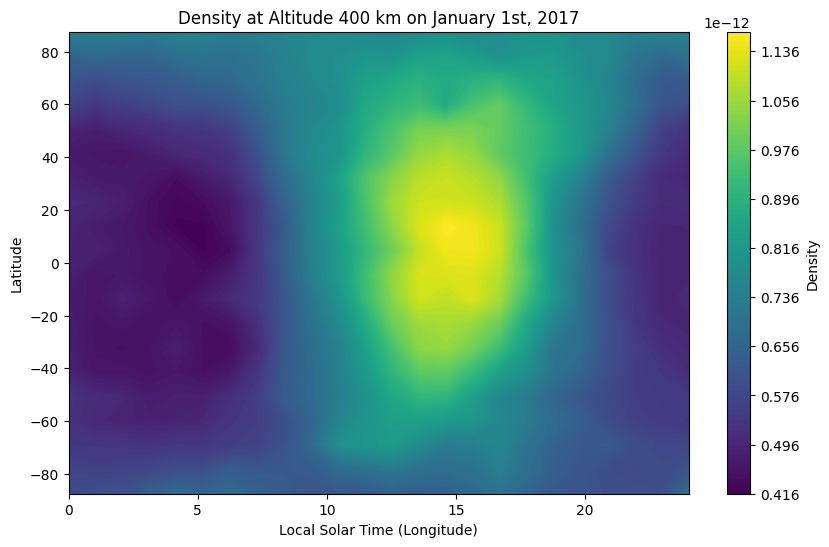

Loading data for year 2017
Concatenating data...


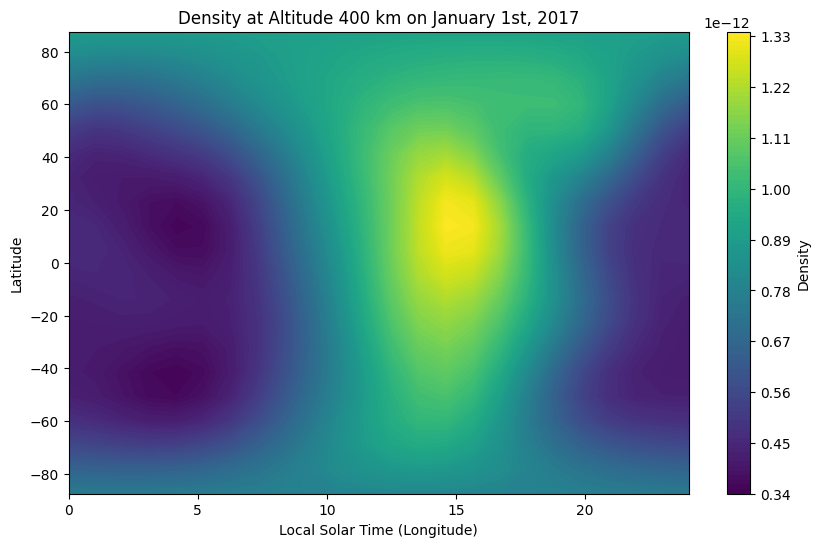

In [11]:
alt = 400

# plot predictions
rho_2017_pr = outputs
rho_2017_01_01 = get_rho_at_date(rho_2017_pr, 1, 1, 2017)
plot_rho_24(rho_2017_01_01, alt)


# plot GT
rho_2017 = prep_data_range([2017])
rho_2017_01_01 = get_rho_at_date(rho_2017, 1, 1, 2017)
plot_rho_24(rho_2017_01_01, alt)
# for i in range(100, 800, 50):
#     plot_rho_24(rho_2017_01_01, i)

